In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd

# Load neighborhood boundaries shapefile with specified encoding
gdf_neighborhood = gpd.read_file('../../datasets/boundaries/neighborhood/raw/BND_ADM_DONG_PG.shp', encoding='cp949')
# Filter neighborhoods where ADM_CD starts with '11' (Seoul)
gdf_neighborhood_seoul = gdf_neighborhood[gdf_neighborhood['ADM_CD'].astype(str).str.startswith('11')]

gdf_neighborhood_seoul

,BASE_DATE,ADM_CD,ADM_NM,geometry
69,20240630,11240750,잠실4동,"POLYGON ((210330.090 547163.722, 210326.158 54..."
552,20240630,11240780,잠실7동,"POLYGON ((206502.446 544771.474, 206494.684 54..."
734,20240630,11240790,잠실2동,"POLYGON ((207564.725 545798.428, 207564.263 54..."
847,20240630,11240770,잠실6동,"POLYGON ((208949.521 547174.423, 208975.386 54..."
917,20240630,11240580,방이2동,"POLYGON ((209981.565 546446.632, 210067.824 54..."
...,...,...,...,...
3170,20240630,11120720,불광2동,"POLYGON ((194734.435 558496.906, 194738.067 55..."
3171,20240630,11120730,응암3동,"POLYGON ((192855.159 555162.328, 192855.111 55..."
3172,20240630,11130660,홍은1동,"POLYGON ((195073.319 554716.263, 195036.172 55..."
3173,20240630,11190660,신길4동,"POLYGON ((192586.782 545131.532, 192588.556 54..."


<Axes: >

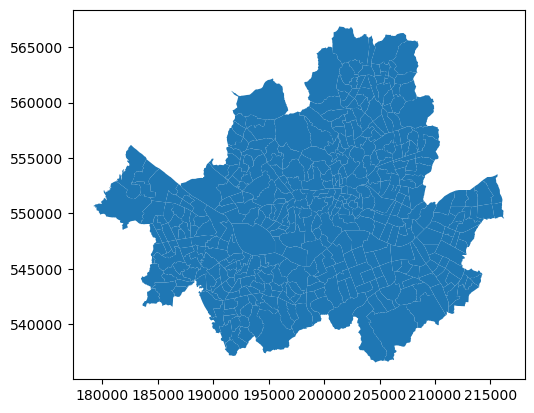

In [41]:
gdf_neighborhood_seoul.plot()

In [42]:
gdf_mountain = gpd.read_file('../../datasets/boundaries/mountain/raw/UPIS_SHP_CUL220.shp', encoding='cp949')
gdf_mountain = gdf_mountain.to_crs(gdf_neighborhood_seoul.crs)

gdf_mountain_park = gpd.read_file('../../datasets/boundaries/mountain/raw/UPIS_C_UQ142.shp', encoding='cp949')
gdf_mountain_park = gdf_mountain_park.to_crs(gdf_neighborhood_seoul.crs)

gdf_river = gpd.read_file('../../datasets/boundaries/river/seoul_river.geojson')
gdf_river = gdf_river.to_crs(gdf_neighborhood_seoul.crs)

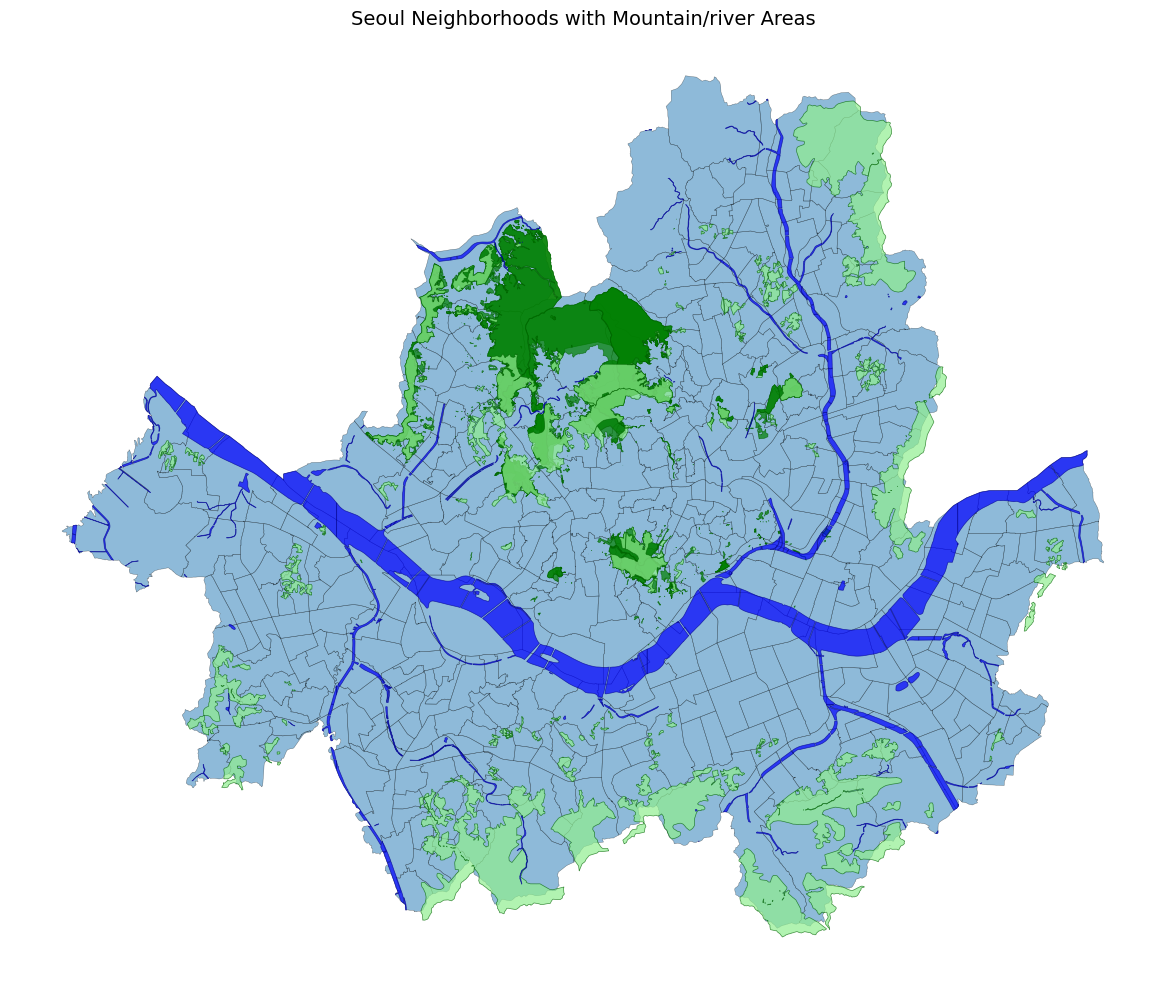

In [43]:
import matplotlib.pyplot as plt

# Create a figure with larger size for better visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot neighborhoods as background
gdf_neighborhood_seoul.plot(ax=ax, alpha=0.5, edgecolor='black', linewidth=0.3)

# Overlay mountains in green
gdf_mountain.plot(ax=ax, color='green', alpha=0.7, edgecolor='darkgreen', linewidth=0.5)

gdf_mountain_park .plot(ax=ax, color='lightgreen', alpha=0.7, edgecolor='darkgreen', linewidth=0.5)

gdf_river.plot(ax=ax, color='blue', alpha=0.7, edgecolor='darkblue', linewidth=0.5)

# Set title
ax.set_title('Seoul Neighborhoods with Mountain/river Areas', fontsize=14)
ax.set_axis_off()  # Remove axes for cleaner look

plt.tight_layout()
plt.show()

In [44]:
# Remove overlapping areas with mountain, mountain_park, and river from neighborhoods
# Use overlay with 'difference' operation to subtract overlapping areas

print("Original neighborhood count:", len(gdf_neighborhood_seoul))

# Method 1: Sequential difference operations
gdf_neighborhood_clean = gdf_neighborhood_seoul.copy()

# Remove mountain areas
try:
    gdf_neighborhood_clean = gpd.overlay(gdf_neighborhood_clean, gdf_mountain, how='difference')
    print("After removing mountain areas:", len(gdf_neighborhood_clean))
except:
    print("No mountain overlap found")

# Remove mountain park areas
try:
    gdf_neighborhood_clean = gpd.overlay(gdf_neighborhood_clean, gdf_mountain_park, how='difference')
    print("After removing mountain park areas:", len(gdf_neighborhood_clean))
except:
    print("No mountain park overlap found")

# Remove river areas
try:
    gdf_neighborhood_clean = gpd.overlay(gdf_neighborhood_clean, gdf_river, how='difference')
    print("After removing river areas:", len(gdf_neighborhood_clean))
except:
    print("No river overlap found")

print("Final cleaned neighborhood count:", len(gdf_neighborhood_clean))

Original neighborhood count: 426
After removing mountain areas: 426
After removing mountain park areas: 426
After removing river areas: 426
Final cleaned neighborhood count: 426


<Axes: >

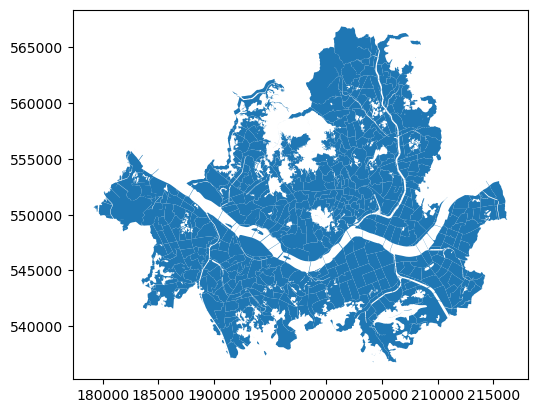

In [45]:
gdf_neighborhood_clean.plot()

In [46]:
# import urban center gis,
gdf_center = gpd.read_file('../../datasets/centers/raw/UPIS_SHP_ZON500.shp', encoding='cp949')

# set CRS to EPSG:5174 (GRS80)
gdf_center = gdf_center.set_crs('EPSG:5174')


# Create type column using LABEL column
def classify_center_type(label):
    if '도심' in label:
        return 'city_center'
    elif '광역중심' in label or '광역 중심' in label:
        return 'regional_center'
    elif '지역중심' in label or '지역 중심' in label:
        return 'district_center'
    elif '지구중심' in label or '지구 중심' in label:
        return 'neighborhood_center'
    else:
        return 'others'

# Create type column
gdf_center['type'] = gdf_center['LABEL'].apply(classify_center_type)

# Check results
print("center_type distribution:")
print(gdf_center['type'].value_counts())

center_type distribution:
neighborhood_center    52
district_center        12
city_center             6
regional_center         6
Name: type, dtype: int64


<Axes: >

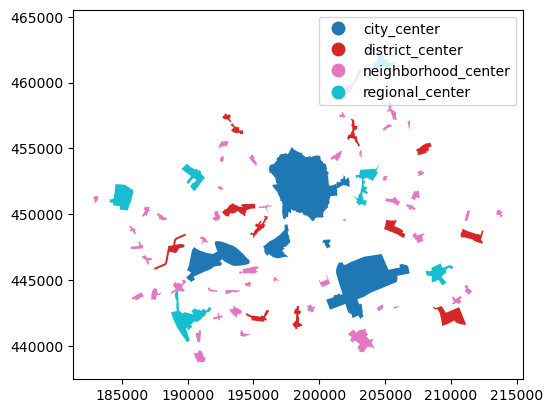

In [47]:
# coloring the map by center type
gdf_center.plot(column='type', legend=True)

In [48]:
# Mapping centers to neighborhoods
# Perform spatial join to map centers to neighborhoods

# Change CRS of gdf_center to match gdf_neighborhood_clean
gdf_center = gdf_center.to_crs(gdf_neighborhood_clean.crs)

# Perform spatial intersection to calculate overlapping areas
gdf_intersection = gpd.overlay(gdf_neighborhood_clean, gdf_center, how='intersection')
gdf_intersection['intersection_area'] = gdf_intersection.geometry.area

# For each neighborhood, find the center type with maximum overlap and sum total intersection area
def process_neighborhood_intersections(group):
    # Sum all intersection areas for this neighborhood
    total_intersection_area = group['intersection_area'].sum()
    
    # Find the center type with maximum intersection area
    max_overlap_idx = group['intersection_area'].idxmax()
    dominant_center_type = group.loc[max_overlap_idx, 'type']
    
    return pd.Series({
        'intersection_area': total_intersection_area,
        'type': dominant_center_type
    })

# Group by neighborhood and apply the processing function
intersection_summary = gdf_intersection.groupby('ADM_CD').apply(process_neighborhood_intersections).reset_index()

# Merge back to the original neighborhood data
gdf_neighborhood_clean = gdf_neighborhood_clean.merge(intersection_summary[['ADM_CD', 'type', 'intersection_area']], on='ADM_CD', how='left')

# Fill NaN values for neighborhoods without centers
gdf_neighborhood_clean['intersection_area'].fillna(0, inplace=True)
gdf_neighborhood_clean['type'] = gdf_neighborhood_clean['type'].fillna('none')

gdf_neighborhood_clean['area'] = gdf_neighborhood_clean.geometry.area

# Calculate intersection ratio
gdf_neighborhood_clean['intersection_ratio'] = gdf_neighborhood_clean['intersection_area'] / gdf_neighborhood_clean['area']

# Set type to 'none' if intersection_ratio is 0.1 or less
gdf_neighborhood_clean.loc[gdf_neighborhood_clean['intersection_ratio'] <= 0.05, 'type'] = 'none'

# Check results
print("Final type distribution:")
print(gdf_neighborhood_clean['type'].value_counts())

Final type distribution:
none                   222
neighborhood_center     72
city_center             62
district_center         41
regional_center         29
Name: type, dtype: int64


C:\Users\seung\AppData\Local\Temp\ipykernel_13844\366743429.py:8: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gdf_intersection = gpd.overlay(gdf_neighborhood_clean, gdf_center, how='intersection')


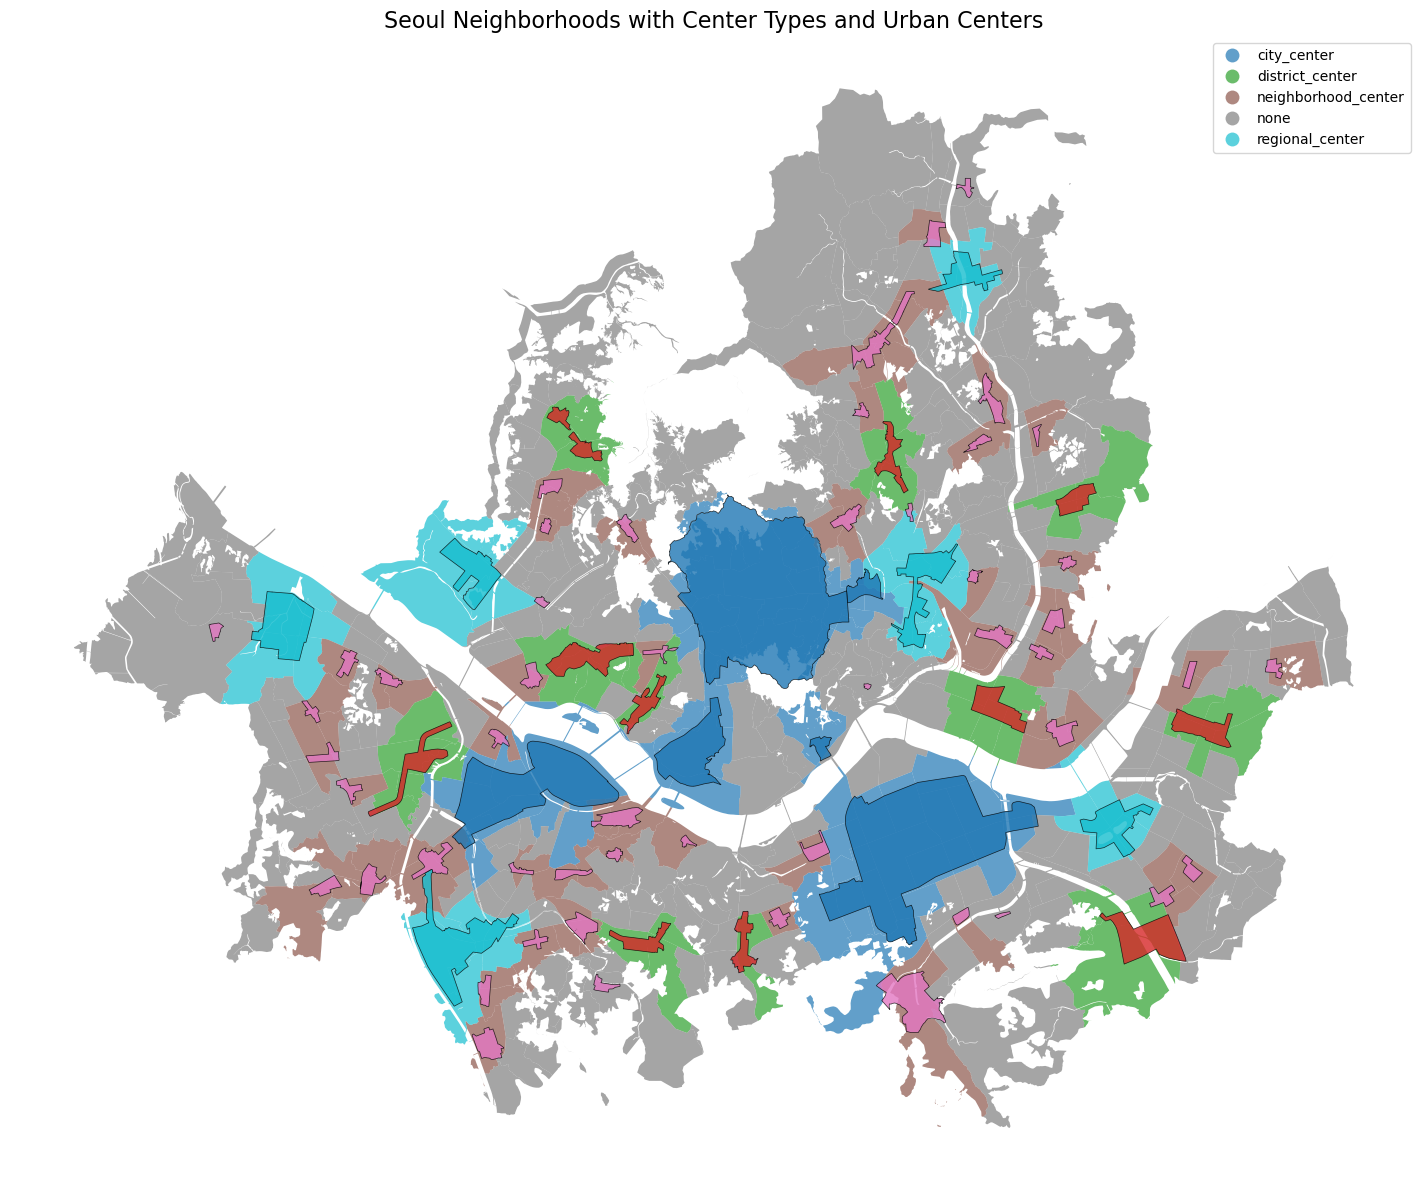

In [50]:
import matplotlib.pyplot as plt

# Create a figure with larger size for better visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot neighborhoods with center types as background
gdf_neighborhood_clean.plot(column='type', legend=True, ax=ax, alpha=0.7)

# Overlay centers on top
gdf_center.plot(column='type', ax=ax, markersize=50, alpha=0.8, edgecolor='black', linewidth=0.5)

# Set title
ax.set_title('Seoul Neighborhoods with Center Types and Urban Centers', fontsize=16)
ax.set_axis_off()  # Remove axes for cleaner look

plt.tight_layout()
plt.show()

In [ ]:
# # Create output directory if it doesn't exist
# import os
# output_dir = '../../datasets/boundaries/neighborhood/processed/'
# os.makedirs(output_dir, exist_ok=True)

# # Save as shapefile with proper encoding
# gdf_neighborhood_seoul.to_file(
#     '../../datasets/boundaries/neighborhood/processed/neighborhoods_with_center_type.shp', 
#     driver='ESRI Shapefile',
#     encoding='cp949'
# )